In [ ]:
#

In [1]:
# Imports
import pandas as pd
import numpy as np
import requests
import json
from json import loads
import datetime 
import matplotlib.pyplot as plt
%matplotlib inline
import time

# Charting-specific imports (matplotlib, matplotlib.finance)
import matplotlib.finance
import matplotlib.ticker as ticker
from matplotlib.finance import candlestick_ohlc,candlestick2_ohlc
#from matplotlib.finance import volume_overlay, volume_overlay2
from matplotlib.dates import  DateFormatter, epoch2num
    # https://matplotlib.org/api/finance_api.html#module-matplotlib.finance
import matplotlib.patheffects as PathEffects
    # [plt.text object].set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])

# API-specific imports (local install required; do NOT use default pip install)
import gdax
    # Python setup.py install with environment activated to install/use
    # Install locally with 'python setup.py install' & development branch of gdax-python checked out
    # Do not use default gdax pip install package - that version of the package is currently broken
        # Default pip install has broken mongo connection and websocket connection close() error

# Pymongo import for connection to local client DB
import pymongo
from pymongo import MongoClient

# Preprocessing Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from keras.utils import to_categorical 

# ML Imports 
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import Embedding, Flatten
from keras.layers import LSTM, GRU
from keras.models import load_model
from keras.models import model_from_json
from keras import backend as K

# autoSR() function import requirements
from sklearn.cluster import MeanShift, estimate_bandwidth
from pandas_datareader import data, wb

###########################################################################
### Force Keras/TF to use CPU backend when GPU present by setting:
    # {'CPU' : 1, 'GPU' : 0}
    
#num_cores = 4
#config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        #inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        #device_count = {'CPU' : 1, 'GPU' : 1})
#session = tf.Session(config=config)
#K.set_session(session)
###########################################################################

# Import to check check for GPU availability for tensorflow backend
from tensorflow.python.client import device_lib

# Verify GPU availability for tensorflow backend
print(device_lib.list_local_devices())
print("==============================================")
print(K.tensorflow_backend._get_available_gpus())

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17426603233232323160
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9222031934
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13052974847322500882
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]
['/job:localhost/replica:0/task:0/device:GPU:0']


In [2]:
# Global variables

# Boolean to drop existing mongo collection/scrape upon scrape() init
dropFlag = False

# Boolean to set size_delta to l2update values for first update to snapshot
#firstUpdate = False
firstUpdate_bids = False
firstUpdate_asks = False

# Value to track if feature_creation_inital() was run
feature_creation_intital_run = False

In [3]:
# Connection establishment

# Establish connection to GDAX public endpoint
public_client = gdax.PublicClient()

# Mongo database and collection specification:
mongo_client = MongoClient('mongodb://localhost:27017/')
db = mongo_client.btcusd_db
btcusd_collection = db.btcusd_collection

In [ ]:
# Function to start scrape process from websocket to mongodb instance
def scrape_start():
    
    # Drop existing collection from db if dropFlag == True (on new scrape):
    if 'btcusd_db' in mongo_client.database_names() and dropFlag is True:
        mongo_client['btcusd_db'].drop_collection('btcusd_collection')
        #print(mongo_client.database_names())
        #print(db.collection_names())
        
    # Start instance of websocket client for L2 Orderbook + L2 update data request and scrape
    wsClient = gdax.WebsocketClient(url="wss://ws-feed.gdax.com", 
                                products=["BTC-USD"],\
                                message_type="subscribe",\
                                channels =["level2"],\
                                mongo_collection=btcusd_collection,\
                                should_print=False)
    
    # Save request open time and start websocket
    time.sleep(4)
    request_time_start=public_client.get_time()
    wsClient.start()
    
    # scrape_time is variable for time between websocket connection start and end
        # Defined in seconds
        # i.e. 600 seconds = scrape running for 10 minutes
    scrape_time = 600

    time.sleep(scrape_time)
    # Save request close time and close websocket
    request_time_end=public_client.get_time()
    wsClient.close()
    
    # Append request times for open/close of websocket stream to dataframe, save to csv
    request_log_df = pd.DataFrame.from_dict({'request start':request_time_start,'request end':request_time_end},orient ='index')
    request_log_df.to_csv("raw_data/request_log.csv",header=True,encoding='utf-8',index =True)

# Function to load and parse data from Mongo into dataframes
def load_parse():
    
    #Collection specification (in database)
    input_data = db.btcusd_collection 
    
    # Create individual dataframes for main response types: snapshot, l2update
    snapshot = pd.DataFrame(list(input_data.find({'type':'snapshot'})))
    l2update = pd.DataFrame(list(input_data.find({'type':'l2update'})))
    
    ### snapshot  response load and parse ###
    
    # Extract asks/bid individual column of array of arrays into lists
    snapshot_asks = snapshot[['asks'][0]][0]
    snapshot_bids = snapshot[['bids'][0]][0]
    
    # Convert list (of array of arrays) into dataframe
    snapshot_asks_df =pd.DataFrame(snapshot_asks)
    snapshot_bids_df =pd.DataFrame(snapshot_bids)
    
    # Rename columns to snapshot array format:
        # snapshot array format: [price, size]
            # [side, price, size] format for one-hot encoding
        # Ask = sell price, bid = buy price
    snapshot_asks_df.rename(columns ={0:'price',1:'size'}, inplace =True)
    snapshot_bids_df.rename(columns ={0:'price',1:'size'}, inplace =True)
    snapshot_asks_df['side'] = "sell"
    snapshot_bids_df['side'] = "buy"
    cols =['side','price','size']
    snapshot_asks_df = snapshot_asks_df[cols]
    snapshot_bids_df = snapshot_bids_df[cols]
    
    ### L2 update response load and parse ###
    
    # Restucture l2update to have [side,price,size] from 'changes' column
    l2update_clean = l2update[['changes','time']]
          
    # Convert changes list of lists -> into array 
    l2_array = np.ravel(l2update_clean['changes']) 
    # Flatten the list and remove outer bracket:
    flattened = [val for sublist in l2_array for val in sublist]
        # Reference: https://stackoverflow.com/questions/11264684/flatten-list-of-lists?
    # Convert back to dataframe and combine with timestamps from l2update:
    changes_df= pd.DataFrame.from_records(flattened)
    # Add time column back to L2 update dataframe
    l2update_formatted = pd.concat([changes_df,l2update_clean['time']],1)
    # Rename columns for [side, price, size]:
    l2update_formatted.rename({0:"side",1:"price",2:"size"}, axis ='columns',inplace=True)
    
    # Save parsed data to csv (API -> Mongo -> Dataframe -> .csv)
    #save_csv()
    
     # Save data to .csv format in raw_data folder
    l2update_formatted.to_csv("raw_data/l2update.csv",header=True,encoding='utf-8',index =False)
    snapshot_asks_df.to_csv("raw_data/snapshot_asks.csv",header=True,encoding='utf-8',index =False)
    snapshot_bids_df.to_csv("raw_data/snapshot_bids.csv",header=True,encoding='utf-8',index =False)

In [11]:
# Read in raw data from csv, 'raw_data' folder
    # 'raw_data' folder has 1hr of scraped data (snapshot + l2 response updates)
    # 'test_data' folder only has 10 minutes of scraped data 
def raw_csv_load():
    global request_log_df
    global snapshot_asks_df
    global snapshot_bids_df
    global l2update_df
  
    snapshot_asks_df = pd.read_csv("raw_data/snapshot_asks.csv",dtype ={'size':float,'size_delta':float})
    snapshot_bids_df = pd.read_csv("raw_data/snapshot_bids.csv",dtype ={'size':float,'size_delta':float})
    l2update_df = pd.read_csv("raw_data/l2update.csv", dtype ={'size':float})
    request_log_df= pd.read_csv("raw_data/request_log.csv")


In [16]:
##### Request 15minute chart data #####

def chart_15m_request(request_log_df):
    
    global chart_15m_df
    request_start = request_log_df['iso'][1]
    request_end = request_log_df['iso'][0]

    # Request 15 minutes of candlestick (open high low close) data from API
        # start time must be in ISO 8601 format for get_product_historic_rates()
    chart_15m = public_client.get_product_historic_rates('BTC-USD', start = request_start, granularity=60)

    # Convert chart data response into dataframes
    chart_15m_df =pd.DataFrame.from_records(chart_15m,columns=["time","low", "high","open" ,"close", "volume"])

    # Reorder columns according to label order required by matplotlib finance package
    chart_15m_df = chart_15m_df[["time","open","high","low","close","volume"]]

    # Reverse/sort timestamp order (without reversal chart labels/axis will be out of order)
    chart_15m_df.sort_values(by='time',axis=0, inplace =True)

    #Convert/sort time to datetime object (for matplotlib chart format requirement)
    chart_15m_df['time'] =pd.to_datetime(chart_15m_df['time'],unit='s')

In [52]:
# Auto support/resistance adapted into function 
    # Using estimate_bandwidth and meanshift() from sklearn.cluster library
    # Source: Adapted from https://github.com/nakulnayyar/SupResGenerator
    # Takes dataframe object with open/high/low/close values 
        # Returns list of auto-generated support and resistance levels for price action
def autoSR(dataframe):
    
    data = chart_15m_df.as_matrix(columns=['close'])
    data2 = data[:len(data)*1]
    bandwidth = estimate_bandwidth(data2, quantile=0.1, n_samples=100)
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(data2)
    ml_results = []
    for k in range(len(np.unique(ms.labels_))):
            my_members = ms.labels_ == k
            values = data[my_members, 0]    
            ml_results.append(min(values))
            ml_results.append(max(values))
            # Remove duplicate S/R level values
            # Using sets
            ml_set =set(ml_results)
            ml_results = list(ml_set)
            # Sort values before return output 
            ml_results.sort()
    
    # Convert ml_results into sorted int array
    ml_results_modified =np.asarray(ml_results)
    ml_results_modified =np.trunc(ml_results_modified).astype(int)
    ml_results_modified = np.sort(ml_results_modified,kind = 'quicksort') 
    # Remove duplicates from int conversion
    ml_results_modified_set=set(ml_results_modified)
    ml_results_modified = list(ml_results_modified_set)
    ml_results_modified = np.sort(ml_results_modified,kind = 'quicksort')
    ml_results_modified
            
    return ml_results_modified

In [58]:
def generate_chart(dataframe):

    matplotlib.rcParams.update({'font.size': 14})
    dataframe = chart_15m_df 
    
    # Generate chart of past 15 minutes with autogenerated support and resistance levels:
    fig, ax = plt.subplots(figsize=(20, 14))
    candlestick2_ohlc(ax,chart_15m_df['open'],chart_15m_df['high'],\
                      chart_15m_df['low'],chart_15m_df['close'],width=2,\
                      colorup='k',colordown='r',alpha=.5)
    ax.set_xticklabels(chart_15m_df['time'] ,rotation=30)
    
    ax.xaxis.set_major_locator(ticker.MaxNLocator(17))
        # n + 2 for proper label set at 20,18/20,14 chart size
    plt.yticks(np.arange(int(min(chart_15m_df['low'])-10), max(chart_15m_df['high'])+10, 10))
    plt.xlabel('Time')
    plt.ylabel('Price (USD)')
    #ax.minorticks_on()
    ax.set_axisbelow(True)
    ax.tick_params(axis='y', pad=10)
    ax.grid(which='major', linestyle='--', linewidth='0.2', color='b')
    matplotlib.pyplot.title("15 Min BTC/USD with Support/Resistance Levels")
    
    ml_results_modified = autoSR(chart_15m_df)
    
    # Add S/R labels to chart
        # count increment is used for staggering of labels in conjunction with modulus
        
    count = 1
    for k in ml_results_modified:
        
        #count = count+ 2.12
        ax.axhline(y=k)
       
        if count%3 == 0:
            plt.text(y=k,s=k,x=count-5,color='blue',rotation=45,size ='large').set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
        if count%3 == 1:
            plt.text(y=k,s=k,x=count+5,color='blue',rotation=45,size ='large').set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
        if count%3 == 2:
            plt.text(y=k,s=k,x=count+16,color='blue',rotation=45, size ='large').set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
        # plt.text reference: https://matplotlib.org/api/text_api.html#matplotlib.text.Text
        
        count = count +1 
    #plt.tight_layout()
    return plt.show()
    #return plt.show(), ml_results

In [59]:
###########################################################################
# Function execution order/testing 

raw_csv_load()

In [60]:
request_log_df.head()

,Unnamed: 0,iso,epoch
0,request end,2018-04-24T04:52:17.094Z,1.524546e+09
1,request start,2018-04-24T03:52:17.030Z,1.524542e+09


In [61]:
chart_15m_request(request_log_df)

In [62]:
chart_15m_df.head()

,time,open,high,low,close,volume
299,2018-04-25 17:28:00,9013.47,9030.81,9013.47,9014.01,140.001493
298,2018-04-25 17:29:00,9014.00,9023.00,9014.00,9023.00,9.025252
297,2018-04-25 17:30:00,9029.55,9047.00,9027.90,9041.83,40.042936
296,2018-04-25 17:31:00,9041.83,9049.42,9032.79,9032.79,32.167996
295,2018-04-25 17:32:00,9031.89,9038.95,9021.00,9021.18,27.186876


In [63]:
autoSR(chart_15m_df)

array([8945, 8970, 8976, 8993, 8995, 9013, 9032, 9035, 9060, 9064, 9095,
       9116, 9121, 9134, 9135, 9153, 9157, 9177])

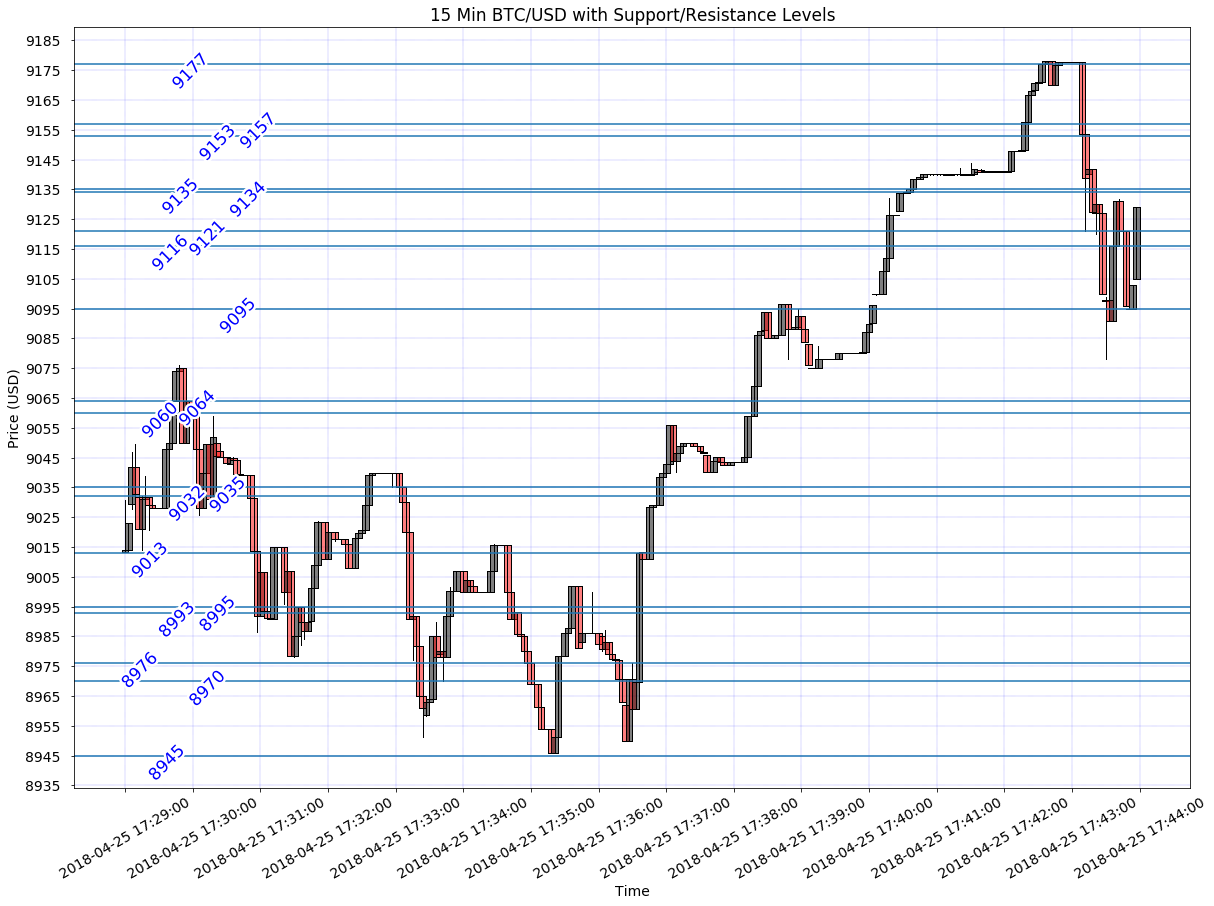

In [64]:
generate_chart(chart_15m_df)